In [2]:
import os
import xml.etree.ElementTree as ET
import shutil
import glob
import random
from sklearn.model_selection import train_test_split
import pandas as pd


In [3]:
# Directories
# TODO : make a validation set here as well

# unzip downloaded data from kaggle link into fruit_dataset folder
train_dir = r'C:\Users\praka\Acads\M_Tech\bits\Sem 3\CV\asmt_labs\asmt2\fruit_dataset\train_zip\train'
test_dir = r'C:\Users\praka\Acads\M_Tech\bits\Sem 3\CV\asmt_labs\asmt2\fruit_dataset\test_zip\test'


In [4]:
def extract_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        boxes.append([filename, width, height, label, xmin, ymin, xmax, ymax])

    return boxes

# Function to read all annotations from a directory
def parse_annotations_from_directory(directory):
    annotations = []
    for file in os.listdir(directory):
        if file.endswith(".xml"):
            xml_file = os.path.join(directory, file)
            annotations.extend(extract_annotations(xml_file))
    return annotations

train_annotations = parse_annotations_from_directory(train_dir)
test_annotations = parse_annotations_from_directory(test_dir)

# Convert to pandas DataFrame for easy manipulation
columns = ['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
train_df = pd.DataFrame(train_annotations, columns=columns)
test_df = pd.DataFrame(test_annotations, columns=columns)

In [5]:
train_df.head()

,filename,width,height,label,xmin,ymin,xmax,ymax
0,apple_1.jpg,0,0,apple,8,15,331,349
1,apple_10.jpg,1500,1500,apple,56,99,1413,1419
2,apple_11.jpg,652,436,apple,213,33,459,258
3,apple_11.jpg,652,436,apple,1,30,188,280
4,apple_11.jpg,652,436,apple,116,5,337,220


In [6]:
train_df.shape, test_df.shape

((465, 8), (117, 8))

In [7]:
train_df = train_df.tail(20)  # temp
train_df.shape, test_df.shape

((20, 8), (117, 8))

In [8]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True, weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
num_classes = 5  # Assuming background + 1 fruit class (apple, banana, orange, mixed)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

In [10]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        # Create a mapping of class names to integers
        self.class_to_index = {'apple': 1, 'banana': 2, 'orange': 3, 'mixed': 4}

    def __getitem__(self, idx):
        # Get the image file
        img_name = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Get bounding boxes
        xmin = self.df.iloc[idx]['xmin']
        ymin = self.df.iloc[idx]['ymin']
        xmax = self.df.iloc[idx]['xmax']
        ymax = self.df.iloc[idx]['ymax']
        boxes = [[xmin, ymin, xmax, ymax]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Get labels
        class_name = self.df.iloc[idx]['label']  # 'label' column contains the fruit names
        label = self.class_to_index.get(class_name, 0)  # Default to 0 if class_name not found
        labels = torch.as_tensor([label], dtype=torch.int64)

        # Create target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        # Apply transformations
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.df)

# Image transformations
transforms = T.Compose([
    T.ToTensor()
])

# Initialize Dataset and DataLoader
batch_size= 5
train_dataset = FruitDataset(train_df, train_dir, transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [11]:
%%time
import torch.optim as optim

learning_rate = 0.005
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
num_epochs = 2
loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        # Zero gradients from previous steps
        optimizer.zero_grad()

        # Forward pass to get the loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass to calculate gradients
        losses.backward()

        # Optimize
        optimizer.step()

        # Accumulate loss for visualization
        running_loss += losses.item()

    # Average loss over an epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/2], Loss: 0.7591
Epoch [2/2], Loss: 0.4200
CPU times: total: 17min 10s
Wall time: 3min 3s


In [12]:
torch.save(model.state_dict(), "fasterrcnn_fruit_detection.pth")

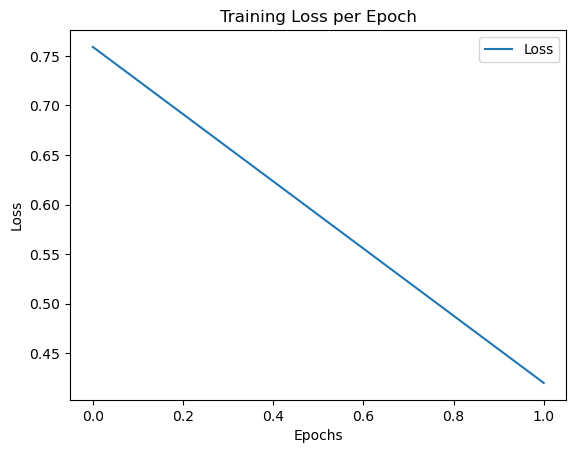

In [13]:
import matplotlib.pyplot as plt
# Visualizing the loss trend over epochs
plt.plot(range(num_epochs), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
# Split the test_df into validation and test datasets (50% split)
val_df, final_test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Create validation and test datasets using the same FruitDataset class
val_dataset = FruitDataset(val_df, test_dir, transforms=transforms)
test_dataset = FruitDataset(final_test_df, test_dir, transforms=transforms)

# Create DataLoader for validation and test datasets
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [34]:
%%time
from torchvision.ops import box_iou
# Function to evaluate on the validation set
def evaluate_model(model, data_loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, targets in data_loader:
            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_boxes = target['boxes'].cpu()
                pred_boxes = output['boxes'].cpu()
                true_labels = target['labels'].cpu()
                pred_labels = output['labels'].cpu()

                # Store the boxes and labels
                all_labels.append((true_boxes, true_labels))
                all_preds.append((pred_boxes, pred_labels))

    return all_labels, all_preds

# Call the evaluate function on the validation dataset
all_labels, all_preds = evaluate_model(model, val_loader)

CPU times: total: 9min 3s
Wall time: 1min 51s


In [36]:
# TODO: [Prakash] length of pred and label isnt same, check and calculate precision recall
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# Initialize the MeanAveragePrecision metric
metric = MeanAveragePrecision()

# Containers for true and predicted labels across all batches
all_pred_labels = []
all_true_labels = []

# Update the metric with the ground truth and predictions
for (true_boxes, true_labels), (pred_boxes, pred_labels) in zip(all_labels, all_preds):
    # Prepare the data in the format expected by torchmetrics
    preds = [{"boxes": pred_boxes, "labels": pred_labels, "scores": torch.ones(pred_boxes.shape[0])}]
    targets = [{"boxes": true_boxes, "labels": true_labels}]
    # Calculate precision and recall
    pred_labels_list = pred_labels.tolist()
    true_labels_list = true_labels.tolist()
    all_pred_labels.extend(pred_labels_list)
    all_true_labels.extend(true_labels_list)

    metric.update(preds, targets)

# Calculate the final mAP, precision, recall
final_metrics = metric.compute()
print(f"Mean Average Precision (map): {final_metrics['map']}")
print(f"Mean Average Precision 50 (map_50): {final_metrics['map_50']}")
print(f"Mean Average Recall 10 (mar_10): {final_metrics['mar_10']}")

# print(f"Precision: {final_metrics['precision']}")
# print(f"Recall: {final_metrics['recall']}")

Mean Average Precision (map): 0.02860289067029953
Mean Average Precision 50 (map_50): 0.050397418439388275
Mean Average Recall 10 (mar_10): 0.16527777910232544
